# EUR-LEX Case Sampling Notebook

### Abstract: 
#### This notebook samples cases for our study from the three chosen topics: Public Health, Data Protection & Social Policy

### Step 1. Find all case identifiers for cases concerning the three topics

In [1]:
# library for reading and writing CSV files
import csv

# Initialise variables to store case identifiers (CELEX numbers) for the three topics
publichealth = []
socialpolicy = []
dataprotection = []

# Find and store all case identifiers for the three topics
with open('../inputdata/all_cases_subjects.csv', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in csvreader:
        if ("health" in row[1].lower()):
            publichealth.append(row[0])
        if ("social policy" in row[1].lower()):
            socialpolicy.append(row[0])
        if ("data" in row[1].lower()):
            dataprotection.append(row[0])
            
# Remove any duplicates
publichealth = list(set(publichealth))
socialpolicy = list(set(socialpolicy))
dataprotection = list(set(dataprotection))

# Print the number of cases found in each topic 
print("# of Public Health cases found:",len(publichealth))
print("# of Social Policy cases found:",len(socialpolicy))
print("# of Data Protection cases found:",len(dataprotection))

# of Public Health cases found: 181
# of Social Policy cases found: 707
# of Data Protection cases found: 42


### Step 2. Identify all case citations that are relevant for each topic

In [2]:
# Import pandas Python library for manipulation and processing of tabular data
import pandas as pd

# Import (read) the file containing the citations for all extracted cases from EUR-LEX
citationsdata = pd.read_csv("../inputdata/all_cases_citations.csv") 
# Retain only those citations that involve cases in our chosen topics:
# 1. Public Health
publichealthcitations = citationsdata[citationsdata['target'].isin(publichealth)]
print("Public Health: ", len(publichealthcitations['target'].unique()))
# 2. Social Policy
socialpolicycitations = citationsdata[citationsdata['target'].isin(socialpolicy)]
print("Social Policy: ",len(socialpolicycitations['target'].unique()))
# 3. Data Protection
dataprotectioncitations = citationsdata[citationsdata['target'].isin(dataprotection)]
print("Data Protectio: ",len(dataprotectioncitations['target'].unique()))

Public Health:  100
Social Policy:  539
Data Protectio:  32


### Step 3. Identify uncited cases

##### I.e. cases from our original set which don't appear in 'citations.csv' (they are never cited). These uncited cases will be taken into account later on for sampling.

In [3]:
# Function to identify uncited cases
def get_uncited_cases(allcases, citedcases):
    return allcases.difference(citedcases)

# 1. Public Health
uncited_publichealth_cases = get_uncited_cases(set(publichealth), set(publichealthcitations['target'].unique()))
print("Public Health: ",len(list(uncited_publichealth_cases)))
# 2. Social Policy
uncited_socialpolicy_cases = get_uncited_cases(set(socialpolicy), set(socialpolicycitations['target'].unique()))
print("Social Policy: ",len(list(uncited_socialpolicy_cases)))
# 3 Data Protection
uncited_dataprotection_cases = get_uncited_cases(set(dataprotection), set(dataprotectioncitations['target'].unique()))
print("Data Protectio: ",len(list(uncited_dataprotection_cases)))

Public Health:  81
Social Policy:  168
Data Protectio:  10


### Step 4. Add the uncited cases into the case citations dataframes

In [4]:
# Function to sort and return a frame of case identifiers sorted by their number of citations - descending order
def get_descending_sorted_frame_of_citations(cases_dataframe):
    return cases_dataframe.groupby('target')['source'].count().reset_index(name='citations').sort_values('citations',ascending=False)

# Apply the above function to the citation frames for each topic
publichealth_citations_sorted_df = get_descending_sorted_frame_of_citations(publichealthcitations)
socialpolicy_citations_sorted_df = get_descending_sorted_frame_of_citations(socialpolicycitations)
dataprotection_citations_sorted_df = get_descending_sorted_frame_of_citations(dataprotectioncitations)

# Add uncited cases
# 1. Public Health
publichealth_newrows = []
for item in list(uncited_publichealth_cases):
    publichealth_newrows.append({'target' : item, 'citations' : 0})
ph_toadd = pd.DataFrame(publichealth_newrows)
# 2. Social Policy
socialpolicy_newrows = []
for item in list(uncited_socialpolicy_cases):
    socialpolicy_newrows.append({'target' : item, 'citations' : 0})
sp_toadd = pd.DataFrame(socialpolicy_newrows)
# 3. Data Protection
dataprotection_newrows = []
for item in list(uncited_dataprotection_cases):
    dataprotection_newrows.append({'target' : item, 'citations' : 0})
dp_toadd = pd.DataFrame(dataprotection_newrows)
    
publichealth_citations_sorted_df = publichealth_citations_sorted_df.append(ph_toadd, ignore_index=True, sort=False)
socialpolicy_citations_sorted_df = socialpolicy_citations_sorted_df.append(sp_toadd, ignore_index=True, sort=False)
dataprotection_citations_sorted_df = dataprotection_citations_sorted_df.append(dp_toadd, ignore_index=True, sort=False)

total_publichealth = len(publichealth_citations_sorted_df['target'])
total_socialpolicy = len(socialpolicy_citations_sorted_df['target'])
total_dataprotection = len(dataprotection_citations_sorted_df['target'])

print("Public Health: ",total_publichealth)
print("Social Policy: ",total_socialpolicy)
print("Data Protectio: ",total_dataprotection)

Public Health:  181
Social Policy:  707
Data Protectio:  42


### Step 5. Citations frequency distribution

In [5]:
data = publichealth_citations_sorted_df
data.head(10)

,target,citations
0,62003CJ0453,32
1,62004CJ0372,24
2,61988CJ0070,12
3,62009CJ0266,10
4,61999CJ0029,10
5,61980CJ0272,9
6,62004CJ0504,8
7,62006CJ0037,8
8,62009CJ0229,8
9,61996CJ0137,8


,citations,quantile
count,181.000000,181.000000
mean,1.933702,0.502762
std,3.649356,0.274695
min,0.000000,0.226519
25%,0.000000,0.226519
50%,1.000000,0.549724
75%,2.000000,0.707182
max,32.000000,1.000000


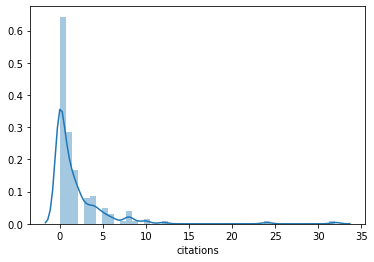

In [16]:
import seaborn as sns
sns.distplot(data['citations'])
data.describe()

In [7]:
publichealth_citations_sorted_df['topic'] = 'public health'
socialpolicy_citations_sorted_df['topic'] = 'social policy'
dataprotection_citations_sorted_df['topic'] = 'data protection'

### Step 6. Sampling cases based on quantiles

In [8]:
publichealth_citations_sorted_df['quantile'] = \
    publichealth_citations_sorted_df['citations'].rank(pct=True)
socialpolicy_citations_sorted_df['quantile'] = \
    socialpolicy_citations_sorted_df['citations'].rank(pct=True)
dataprotection_citations_sorted_df['quantile'] = \
    dataprotection_citations_sorted_df['citations'].rank(pct=True)

In [9]:
def sampleSize(population_size, margin_error=.05, confidence_level=.99, sigma=1/2):
    alpha = 1 - (confidence_level)
    # dictionary of confidence levels and corresponding z-scores
    # computed via norm.ppf(1 - (alpha/2)), where norm is
    zdict = {
        .90: 1.645,
        .91: 1.695,
        .99: 2.576,
        .97: 2.17,
        .94: 1.881,
        .93: 1.812,
        .95: 1.96,
        .98: 2.326,
        .96: 2.054,
        .92: 1.751
    }
    if confidence_level in zdict:
        z = zdict[confidence_level]
    else:
        from scipy.stats import norm
        z = norm.ppf(1 - (alpha/2))
    N = population_size
    M = margin_error
    a = z**2 * sigma**2 * (N / (N-1))
    b = M**2 + ((z**2 * sigma**2)/(N-1))
    return int(round(a/b,0))

In [10]:
sample_size_publichealth = sampleSize(total_publichealth, margin_error=.1, confidence_level=.95)
sample_size_socialpolicy = sampleSize(total_socialpolicy, margin_error=.1, confidence_level=.95)
sample_size_dataprotection = sampleSize(total_dataprotection, margin_error=.1, confidence_level=.95)

print(sample_size_publichealth)
print(sample_size_socialpolicy)
print(sample_size_dataprotection)

63
85
29


In [ ]:
Total  
Public Health:  181
Social Policy:  707
Data Protectio:  42

In [11]:
def sample_ordered_index(df, size):
    """the function assumes ordered frame by rank"""
    if size < len(df.index):
        bins = len(df.index)/size
        index_sample = [df.index[int(i*bins)] for i in range(size)]
    else:
        print('Sample size is bigger than the popolation')
    return df[df.index.isin(index_sample)]

In [12]:
sample_cases_publichealth = sample_ordered_index(
    publichealth_citations_sorted_df, sample_size_publichealth)
sample_cases_socialpolicy = sample_ordered_index(
    socialpolicy_citations_sorted_df, sample_size_socialpolicy)
sample_cases_dataprotection = sample_ordered_index(
    dataprotection_citations_sorted_df, sample_size_dataprotection)

In [13]:
sample_cases_dataprotection.head()

,target,citations,topic,quantile
0,62000CJ0465,17,data protection,1.000000
1,62009CJ0092,16,data protection,0.976190
2,62001CJ0101,15,data protection,0.940476
4,61998CJ0223,11,data protection,0.904762
5,62006CJ0524,10,data protection,0.880952


In [14]:
# tidyfile and write
df = sample_cases_publichealth\
    .append(sample_cases_socialpolicy)\
    .append(sample_cases_dataprotection)
df['quantile'] = [round(x,2) for x in df['quantile']]
df.sort_values('citations', ascending=False)\
    .reset_index()\
    [['quantile','target','citations','topic']]\
    .rename(columns = {'target':'source'})\
    .to_csv('../inputdata/sampled_cases.csv', index=False)